## Introduction
Optical Character Recognition (OCR) is critical in Computer Vision and Artificial Intelligence. Its applications span a variety of sectors, including document digitization, automated data entry, and license plate recognition. Unlike typical image processing tasks, OCR identifies, extracts, and digitizes written or printed characters from images or documents. This technology bridges the gap between the physical text world and the digital realm, allowing computers to understand and utilize written text within images.

This guide will show you how to run a powerful OCR model Paddle-OCR and deploy it using SnapML. You can read more about PaddleOCR in their official repo [here](https://github.com/PaddlePaddle/PaddleOCR).

## Dependencies

### Python Inference
To test the model in our Python framework and convert it into a SnapML-compatible ONNX graph, we've prepared [this](https://github.com/opencv-ai/paddle-ocr) repository. You need to clone it and install dependencies.

In [1]:
!git clone https://github.com/opencv-ai/paddle-ocr
!cd paddle-ocr && pip install -r requirements.txt
!pip install paddlepaddle==2.6.2 paddle2onnx onnx onnxruntime "numpy>=1.23,<2" Pillow

Cloning into 'paddle-ocr'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 200 (delta 57), reused 191 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (200/200), 25.35 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Error downloading object: weights/changed/detector_v3.onnx (dd8cc64): Smudge error: Error downloading weights/changed/detector_v3.onnx (dd8cc64ea001bce59e68f5d3218793f5835303fac37a72095501f1a6d16ad010): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /content/paddle-ocr/.git/lfs/logs/20251115T195134.698344169.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: weights/changed/detector_v3.onnx: smudge filter lfs failed
You can inspect what was checked out with 'git status'
and retry with '

## Training (optional)

We've prepared a separate notebook with instructions on launching the PaddleOCR training scripts. We didn't train the model on our side and reproduce the authors' instructions there; therefore, we can't guarantee that the results will match the authors' pre-trained model we used. The training notebook can be found [here](https://github.com/Snapchat/snapml-templates/blob/main/Optical%20Character%20Recognition/Optical%20Character%20Recognition%20-%20OCR%20Training.ipynb).

## Export

We need to convert the model weights into ONNX format to run our Python pipeline and use it with SnapML. We provide converted models in our Python repository, and you may skip these steps if you want to.

We used the pre-trained checkpoints. You need to download it or train your own models. To prepare your own weights for convertation, follow [the instructions](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.6/doc/doc_en/inference_en.md#1-convert-training-model-to-inference-model) to save inference state checkpoint.

Launch the cell below to download pre-trained weights.

In [2]:
%cd paddle-ocr
!mkdir paddle_weights

!wget -P ./paddle_weights/ https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar
!cd paddle_weights && tar -xf en_PP-OCRv3_det_infer.tar && rm -rf en_PP-OCRv3_det_infer.tar
!wget -P ./paddle_weights/ https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar
!cd paddle_weights && tar -xf en_number_mobile_v2.0_rec_infer.tar && rm -rf en_number_mobile_v2.0_rec_infer.tar

/content/paddle-ocr
--2025-11-15 19:52:00--  https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 113.137.57.33, 2402:2b40:7000:628:0:ff:b0e8:88da
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|113.137.57.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4003840 (3.8M) [application/x-tar]
Saving to: ‘./paddle_weights/en_PP-OCRv3_det_infer.tar’

en_PP-OCRv3_det_inf 100%[===================>]   3.82M   599KB/s    in 12s     

2025-11-15 19:52:13 (321 KB/s) - ‘./paddle_weights/en_PP-OCRv3_det_infer.tar’ saved [4003840/4003840]

--2025-11-15 19:52:13--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 113.137.57.33, 2402:2b40:7000:628:0:ff:b0e8:88da
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|113.137.57.33|:443... connected.
HTTP request

Now you need to convert the weights into ONNX using Paddle2ONNX.

In [3]:
!paddle2onnx --model_dir ./paddle_weights/en_PP-OCRv3_det_infer \
             --model_filename inference.pdmodel \
             --params_filename inference.pdiparams\
             --save_file ./weights/source/en_PP-OCRv3_det_infer_fixed_shape.onnx \
             --enable_dev_version False \
             --input_shape_dict "{'x':[1,3,640,640]}" \
             --opset_version 11 \
             --enable_onnx_checker True

!paddle2onnx --model_dir ./paddle_weights/en_number_mobile_v2.0_rec_infer \
             --model_filename inference.pdmodel \
             --params_filename inference.pdiparams\
             --save_file ./weights/source/en_number_mobile_v2.0_rec_infer_fixed_shape.onnx \
             --enable_dev_version False \
             --input_shape_dict "{'x':[1,3,32,832]}" \
             --opset_version 11 \
             --enable_onnx_checker True

/bin/bash: line 1: paddle2onnx: command not found
/bin/bash: line 1: paddle2onnx: command not found


Let's simplify our models using onnxsim.

In [4]:
!python -m onnxsim ./weights/source/en_PP-OCRv3_det_infer_fixed_shape.onnx ./weights/source/en_PP-OCRv3_det_infer_fixed_shape_optimized.onnx
!python -m onnxsim ./weights/source/en_number_mobile_v2.0_rec_infer_fixed_shape.onnx ./weights/source/en_number_mobile_v2.0_rec_infer_fixed_shape_optimized.onnx

/usr/bin/python3: No module named onnxsim
/usr/bin/python3: No module named onnxsim


As the final step, we need to correct some operations to make the model compatible with SnapML

In [5]:
!python ./weights/fix_detector.py --input_path ./weights/source/en_PP-OCRv3_det_infer_fixed_shape_optimized.onnx --output_path ./weights/changed/detector_v3.onnx

Traceback (most recent call last):
  File "/content/paddle-ocr/./weights/fix_detector.py", line 1, in <module>
    import onnx
ModuleNotFoundError: No module named 'onnx'


In [6]:
!python ./weights/fix_recognizer.py --input_path ./weights/source/en_number_mobile_v2.0_rec_infer_fixed_shape_optimized.onnx --output_path ./weights/changed/recognition_v1.onnx

Traceback (most recent call last):
  File "/content/paddle-ocr/./weights/fix_recognizer.py", line 1, in <module>
    import onnx
ModuleNotFoundError: No module named 'onnx'


## Testing

Let's run our ONNX pipeline on some images. We support a text detection pipeline (use `--run_detection` argument) or an entire pipeline with recognition (`--run_pipeline`). Note that these arguments conflict with each other.

In [7]:
!python inference.py --det_model_dir ./weights/changed/detector_v3.onnx \
                     --rec_model_dir ./weights/changed/recognition_v1.onnx \
                     -i ./images/test2.png \
                     --run_detection

Traceback (most recent call last):
  File "/content/paddle-ocr/inference.py", line 1, in <module>
    from pipeline import TextPipeline
  File "/content/paddle-ocr/pipeline.py", line 18, in <module>
    from detector import TextDetector
  File "/content/paddle-ocr/detector.py", line 17, in <module>
    from utils import create_operators, transform
  File "/content/paddle-ocr/utils.py", line 2, in <module>
    import onnx
ModuleNotFoundError: No module named 'onnx'


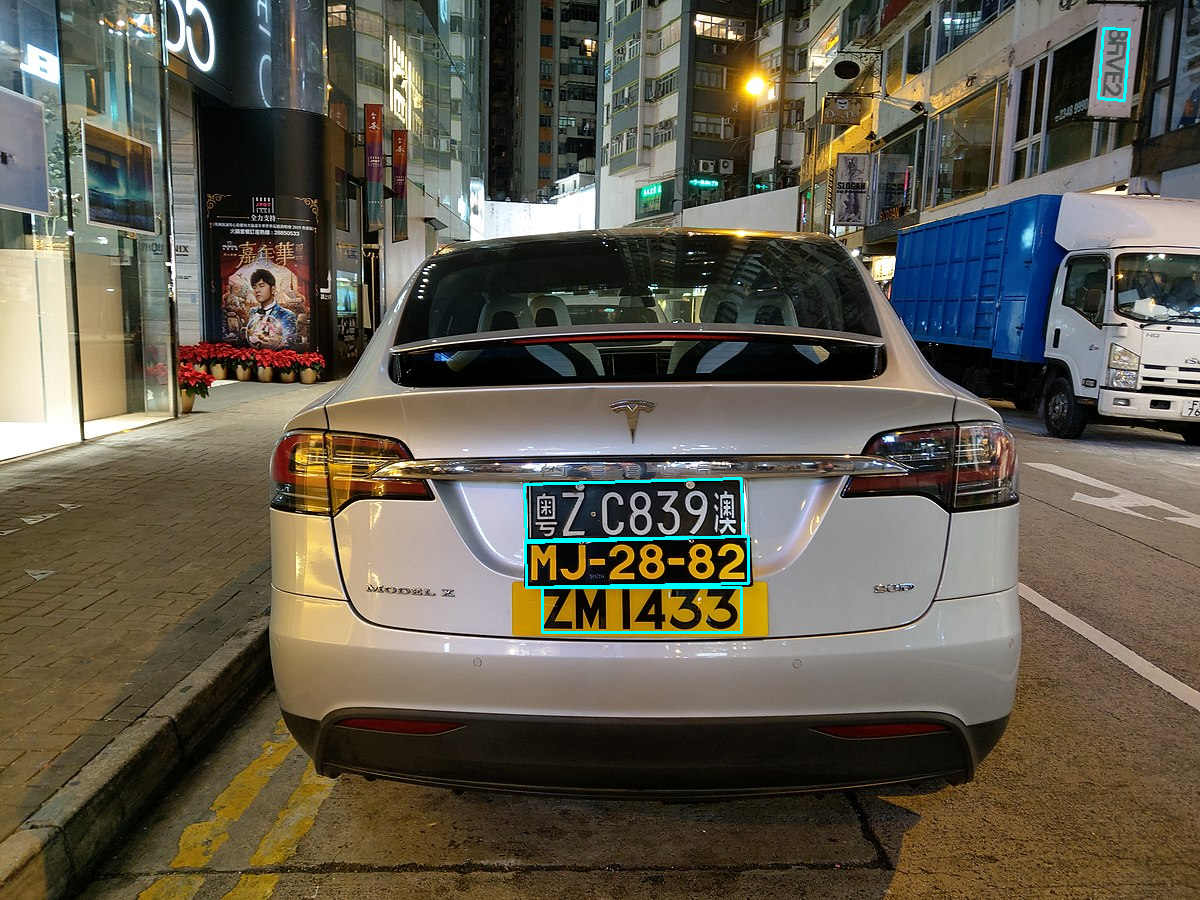

In [8]:
from PIL import Image
Image.open("./images/results/test2.png")

In [9]:
!python inference.py --det_model_dir ./weights/changed/detector_v3.onnx \
                     --rec_model_dir ./weights/changed/recognition_v1.onnx \
                     -i ./images/test1.png \
                     --run_pipeline \
                     --rec_char_dict_path ./rec_char_dict/en_dict.txt

Traceback (most recent call last):
  File "/content/paddle-ocr/inference.py", line 1, in <module>
    from pipeline import TextPipeline
  File "/content/paddle-ocr/pipeline.py", line 18, in <module>
    from detector import TextDetector
  File "/content/paddle-ocr/detector.py", line 17, in <module>
    from utils import create_operators, transform
  File "/content/paddle-ocr/utils.py", line 2, in <module>
    import onnx
ModuleNotFoundError: No module named 'onnx'


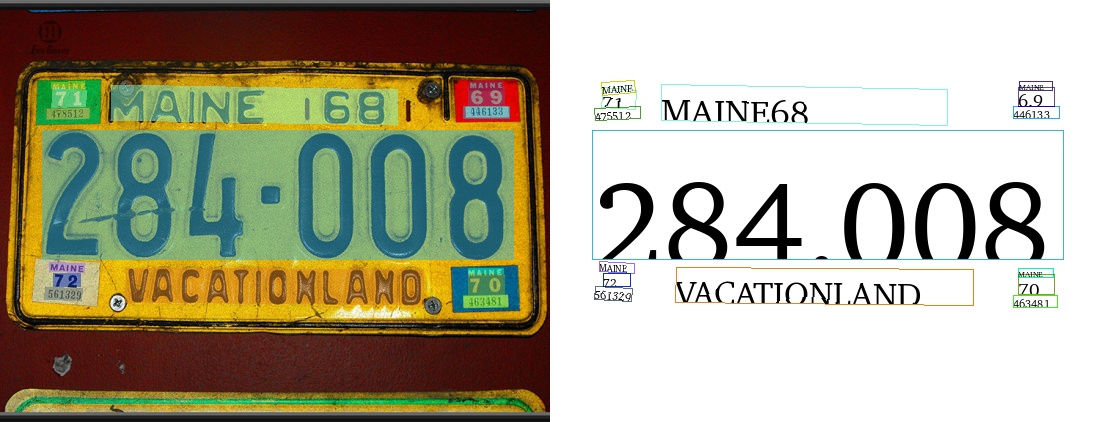

In [10]:
Image.open("./images/results/test1.png")

### Expectations

- Works well on full frontal views with very little obstruction in text, where text is horizontally placed. License plates are a good example where it works well, front facing billboards, book covers with horizontal text are good too.
- Doesn’t work well on use cases where the text is slanted (for example road signs that may be angled, or a book cover that is placed on a table on an angle etc).
- Text that is very exaggerated or highly stylized is also one where it doesn’t work very well. If there are ornaments near the text, it tends to capture those as well and try to recognize them as special characters.
- Sometimes, the model is not able to recognize spaces, leading to confusing outputs.
- Big chunks of small text are also a hit or miss.
